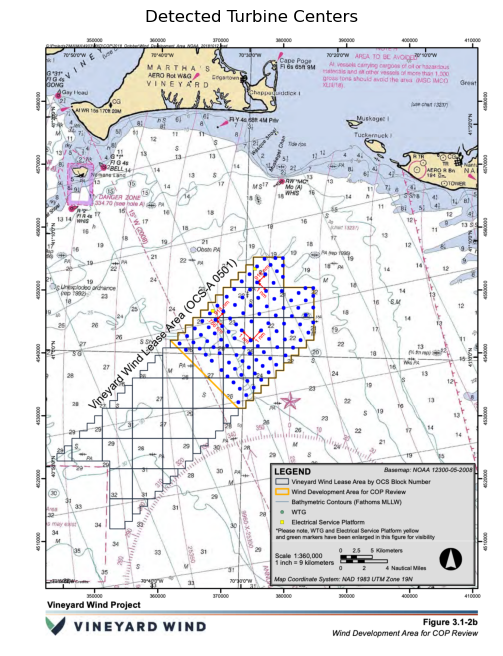

The geographic coordinates of the turbines have been saved to /home/yugao/SWOT_L2/data/processed/turbines_geo.json


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# Read the main image
img = cv2.imread('/home/yugao/SWOT_L2/data/external/Vineyardwind_wind_development_area.png')

# Define the green color range in HSV
lower_green = np.array([40, 100, 100], np.uint8)
upper_green = np.array([80, 255, 255], np.uint8)

# Mask the lower 1/4 of the image to exclude the legend
height = img.shape[0]
mask_height = height - int(height * 0.25)
mask = np.ones(img.shape[:2], dtype="uint8")  # White mask
cv2.rectangle(mask, (0, mask_height), (img.shape[1], height), 0, -1)  # Black mask on the lower 1/4

# Mask the lower 1/4 of the image to exclude the legend
height = img.shape[0]
mask_height = height - int(height * 0.25)
mask = np.ones(img.shape[:2], dtype="uint8")  # White mask
cv2.rectangle(mask, (0, mask_height), (img.shape[1], height), 0, -1)  # Black mask on the lower 1/4

# Apply the mask to the image
img_masked = cv2.bitwise_and(img, img, mask=mask)


# Convert image to HSV color space
hsv = cv2.cvtColor(img_masked, cv2.COLOR_BGR2HSV)

# Create a binary mask where the green turbines are white
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the centroid of each turbine contour and draw a red circle at each centroid
turbine_centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        turbine_centers.append((cX, cY))
        cv2.circle(img, (cX, cY), 5, (255, 0, 0), -1)

# Display the image with the detected turbines
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Detected Turbine Centers')
plt.show()

# The reference pixel coordinates of the lowermost turbine
reference_pixel = (812, 738)

# The corrected geographic coordinates of the reference turbine
reference_geo = (41.8, -70.32)

# Assuming the scale from the map's legend
scale = 1 / 360000

# Convert the pixel distances to degrees using the scale ratio
turbines_geo = []
for center in turbine_centers:
    delta_x = center[0] - reference_pixel[0]
    delta_y = reference_pixel[1] - center[1]  # Y is inverted in image coordinates
    lat = reference_geo[0] - (delta_y * scale)  # Latitude increases as we go up
    lon = reference_geo[1] + (delta_x * scale)  # Longitude increases as we go right
    turbines_geo.append({'latitude': lat, 'longitude': lon})

# Save the geographic coordinates to a JSON file
json_filename = '/home/yugao/SWOT_L2/data/processed/turbines_geo.json'
with open(json_filename, 'w') as json_file:
    json.dump(turbines_geo, json_file)

print(f'The geographic coordinates of the turbines have been saved to {json_filename}')
